<a href="https://colab.research.google.com/github/shashank3110/ASL-Finger-Spelling-Recognition/blob/master/GAN_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
tf.__version__

'2.0.0-rc1'

In [0]:
# To generate GIFs
!pip install -q imageio


In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers,models
import time

from IPython import display


4423680/4422102 [==============================] - 0s 0us/step


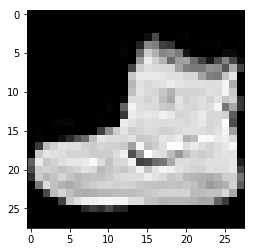

In [0]:
(train_images,train_labels),(test_images,test_labels) = tf.keras.datasets.\
fashion_mnist.load_data()
#before normalization
plt.imshow(train_images[0],cmap='gray')

In [0]:
train_images.shape
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
#train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
#print(train_images[2])
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
# train_images_normalized =[]
# for image in train_images:
#   image = (image-image.mean())/image.std()
#   train_images_normalized.append(image)
# train_images = train_images_normalized
#train_images = (train_images - 255) / 255 # Normalize the images to [0, 1]
#print(train_images[2])

(28, 28)


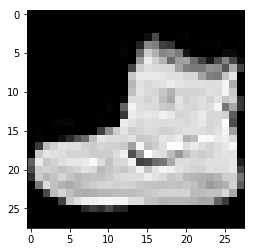

In [0]:
#after normalization
print(train_images[0][:,:,0].shape)
plt.imshow(train_images[0][:,:,0],cmap='gray')

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256


In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) # Deconvolution/learnable upsampling
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # Deconvolution/learnable upsampling
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


(28, 28)


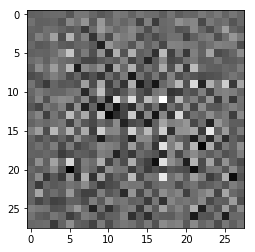

In [0]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image[0, :, :, 0].shape)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [0]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[-0.00184636]], shape=(1, 1), dtype=float32)


In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)# 1 for real image 
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)# 0 for fake image 
    total_loss = real_loss + fake_loss
    return total_loss


In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  models.save_model(generator,'generator_model')
  models.save_model(discriminator,'discriminator_model')


In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [0]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


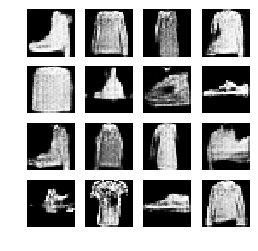

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: generator_model/assets
INFO:tensorflow:Assets written to: discriminator_model/assets
CPU times: user 4min 53s, sys: 1min 17s, total: 6min 11s
Wall time: 19min 31s


In [0]:
%%time
train(train_dataset, EPOCHS)


In [0]:
saved_dmodel_dir = 'discriminator_model' #checkpoint_dir
saved_gmodel_dir = 'generator_model'
dconverter = tf.lite.TFLiteConverter.from_saved_model(saved_dmodel_dir)
gconverter = tf.lite.TFLiteConverter.from_saved_model(saved_gmodel_dir)
tflite_dmodel = dconverter.convert()
open("converted_dmodel.tflite", "wb").write(tflite_dmodel)
tflite_gmodel = gconverter.convert()
open("converted_gmodel.tflite", "wb").write(tflite_gmodel)

9176568

In [0]:
! ls

converted_dmodel.tflite  image_at_epoch_0033.png  image_at_epoch_0069.png
converted_gmodel.tflite  image_at_epoch_0034.png  image_at_epoch_0070.png
discriminator_model	 image_at_epoch_0035.png  image_at_epoch_0071.png
generator_model		 image_at_epoch_0036.png  image_at_epoch_0072.png
image_at_epoch_0001.png  image_at_epoch_0037.png  image_at_epoch_0073.png
image_at_epoch_0002.png  image_at_epoch_0038.png  image_at_epoch_0074.png
image_at_epoch_0003.png  image_at_epoch_0039.png  image_at_epoch_0075.png
image_at_epoch_0004.png  image_at_epoch_0040.png  image_at_epoch_0076.png
image_at_epoch_0005.png  image_at_epoch_0041.png  image_at_epoch_0077.png
image_at_epoch_0006.png  image_at_epoch_0042.png  image_at_epoch_0078.png
image_at_epoch_0007.png  image_at_epoch_0043.png  image_at_epoch_0079.png
image_at_epoch_0008.png  image_at_epoch_0044.png  image_at_epoch_0080.png
image_at_epoch_0009.png  image_at_epoch_0045.png  image_at_epoch_0081.png
image_at_epoch_0010.png  image_at_epoch_0046.png 

In [0]:
from google.colab import files
#!  converted_dmodel.tflite

In [0]:
files.download('converted_gmodel.tflite')
files.download('converted_gmodel.tflite')
#files.download('training_checkpoints')
files.download('image_at_epoch_0005.png')
files.download('image_at_epoch_0050.png')
files.download('image_at_epoch_0100.png')

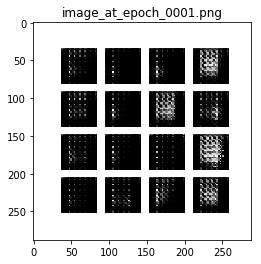

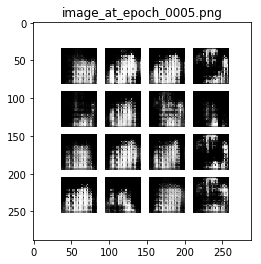

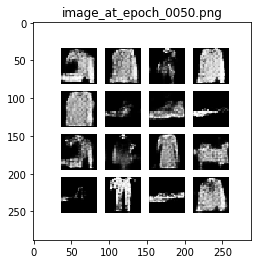

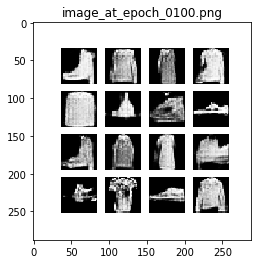

In [0]:
# import os
#fig = plt.figure(figsize=(4,4))
res_path= ['image_at_epoch_0001.png','image_at_epoch_0005.png','image_at_epoch_0050.png','image_at_epoch_0100.png']
for res in res_path :
  plt.subplots()
  plt.title(res)
  img = plt.imread(res)
  plt.imshow(img, cmap='gray')
plt.show()

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))



In [0]:
dir(tf.keras.datasets)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'boston_housing',
 'cifar10',
 'cifar100',
 'fashion_mnist',
 'imdb',
 'mnist',
 'reuters']